# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

from pprint import pprint
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

import seaborn as sns

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Overview of raw data

In [3]:
display(portfolio.shape)
portfolio # in total 10 unique offers

(10, 6)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [5]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


## Analyze and prepare portfolio data

In [6]:
def analize_portfolio(portfolio):
    portfolio = portfolio.copy() # do not alter the original values outside of this function
    print( "Are there any null values in portfolio?", True in list(portfolio.isnull().any())) # ...no null values
    
    # get all possible channel_types
    channel_types = set()
    for l in portfolio.channels.to_list(): # value encoding is indeeed a python list
        channel_types.update(l)
    print("channel_types", channel_types)

    print("offer_type possible values:\n", portfolio.offer_type.value_counts())
    
    return portfolio

analize_portfolio(portfolio)

Are there any null values in portfolio? False
channel_types {'web', 'social', 'mobile', 'email'}
offer_type possible values:
 bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [7]:
def prepare_portfolio(portfolio):
    
    portfolio = portfolio.copy() # do not alter the original values outside of this function
    
    # get all possible channel_types
    channel_types = set()
    for l in portfolio.channels.to_list():
        channel_types.update(l)

    # create marker columns for each channel type. 1 exists, 0 does not exists. 0-1 availability matrix.
    for channel_type in channel_types:
        portfolio['ch_' + channel_type] = portfolio['channels'].apply(lambda x: 1 if channel_type in x else 0)
    
    # convert offer_type from string to 0-1 availability matrix
    offer_type_dummies = pd.get_dummies(portfolio.offer_type, prefix='ot')
    portfolio = pd.concat([portfolio, offer_type_dummies], axis=1, sort=False)
    
    # encode offer_type from string to int
    le = LabelEncoder()
    portfolio['offer_type_encoded'] = portfolio[['offer_type']].apply(le.fit_transform)
    
    # remove columns that have been converted
    portfolio.drop(['channels'], axis=1, inplace=True)
    
    # create an information dictionary of converted columns
    portfolio_info = {'channel_types': list(channel_types),
                      'offer_types:': set(dict(portfolio.offer_type.value_counts()).keys()),
                      'offer_type encoding': dict(zip(le.classes_, le.transform(le.classes_)))}
    return portfolio, portfolio_info

pportfolio, portfolio_info = prepare_portfolio(portfolio)
pprint(portfolio_info)
pportfolio.head()


{'channel_types': ['web', 'social', 'mobile', 'email'],
 'offer_type encoding': {'bogo': 0, 'discount': 1, 'informational': 2},
 'offer_types:': {'informational', 'discount', 'bogo'}}


,reward,difficulty,duration,offer_type,id,ch_web,ch_social,ch_mobile,ch_email,ot_bogo,ot_discount,ot_informational,offer_type_encoded
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1,0,0,1,2
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1,1,0,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,1


## Analyze and prepare profile data

In [8]:
def analyze_profile(profile):
    profile = profile.copy()
    
    print( "Are there any null values in profile?", True in list(profile.isnull().any())) # ...no null values
    display(profile.isnull().any())# ... in gender and income
    profile.shape
    
    print("#null_gender", profile[profile.gender.isna()].shape[0])
    print("#null_income", profile[profile.income.isna()].shape[0])
    # both row count with null values is 2175. Are they the same?
    print("Where gender is NaN then income is also Nan?", list(profile.gender.isna()) == list(profile.income.isna()))
    print(profile.age.value_counts())
    print("Age of 118 has exactly 2175 hits. The same count as number of NaNs. So are they the same rows?")
    print("- " + str(profile[profile.age == 118].income.isnull().count() == 2175))
    profile.age = profile.age.apply(lambda x: np.nan if x == 118 else x) # reset age==118 to NaN
    profile_ids_with_nulls = profile[profile.gender.isnull() & profile.age.isnull() & profile.income.isnull()].id.unique()
    print("are those person with null entries even listed in transcript?",
          transcript[transcript.person.isin(profile_ids_with_nulls)].shape[0] > 0)
    
    return profile_ids_with_nulls
    
profile_ids_with_nulls = analyze_profile(profile)
# profile_ids_with_nulls can be deleted in transcript

Are there any null values in profile? True


gender               True
age                 False
id                  False
became_member_on    False
income               True
dtype: bool

#null_gender 2175
#null_income 2175
Where gender is NaN then income is also Nan? True
118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64
Age of 118 has exactly 2175 hits. The same count as number of NaNs. So are they the same rows?
- True
are those person with null entries even listed in transcript? True


In [9]:
def prepare_profile(profile ):
    profile = profile.copy()  # do not alter the original values outside of this function
    
    # correct highly possible fake value with age==118
    profile.age = profile.age.apply(lambda x: np.nan if x == 118 else x) # reset age==118 to NaN
    print("Number of rows with age 118 after setting age=NaN: " + str(profile[profile.age == 118].income.isnull().count()))
    
    # delete persons with only null entries from our data set
    profile = profile[~(profile.gender.isnull() & profile.age.isnull() & profile.income.isnull())]
    # convert age to int
    profile['age'] = profile['age'].astype(int)
    # encode gender category to numerical
    le = LabelEncoder()
    profile['gender_encoded'] = profile[['gender']].apply(le.fit_transform)
    # convert int date to real datetime
    profile['membership_startdate'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    return profile

pprofile = prepare_profile(profile)
pprofile

Number of rows with age 118 after setting age=NaN: 0


,gender,age,id,became_member_on,income,gender_encoded,membership_startdate
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0,2017-07-15
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0,2017-05-09
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1,2018-04-26
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1,2018-02-09
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1,2017-11-11
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,0,2018-06-04
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,1,2018-07-13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,1,2017-01-26
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,0,2016-03-07


## Analyze and prepare transcript data

In [10]:
print( "Are there any null values in transcript?", True in list(transcript.isnull().any())) # ...no null values

Are there any null values in transcript? False


In [11]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
# the value column still has nested json encoded. Lets' analyse that structure...

def analyze_transcript(transcript):
    transcript = transcript.copy() # do not alter the original values outside of this function
    
    # find all possible value json keys and store it in a new column `value_type`
    transcript_value_keys = set()
    for d in transcript.value:
        transcript_value_keys.update(d.keys())
    print("value json keys: ", transcript_value_keys)
    transcript['value_type'] = transcript.value.apply(lambda d: next(iter(d.keys())))
    transcript['value_num_keys'] = transcript.value.apply(lambda d: len(d.keys()))    
    print("max number of value json keys: ", transcript.value.apply(lambda d: len(d.keys())).max())
    # there are json encoded values with more than 1 key. let's find all the possible key combinations...
    json_key_combinations = set()
    for _, row in transcript[transcript['value_num_keys'] > 1].iterrows():
        #print(row['value'])
        #print("hae", set(dict(row['value'])))
        json_key_combinations.update(set(dict(row['value'])))
        break

    print("all json key combinations:")
    pprint(json_key_combinations) # only 1 combination: {'offer_id', 'reward'}
                                                         
    print("all value json keys: ", transcript_value_keys)

    # find all event (string) types
    event_types = set(dict(transcript.event.value_counts()).keys())
    print("All event types: ", event_types)

    # event and value_types seem to be related.
    # lets create a mapping table/dict to seee which json keys corresponds to an event type
    event_value_mapping = {}
    for et in event_types:
        event_value_mapping[et] = set(transcript[transcript.event == et].value.apply(lambda x: ','.join(list(x.keys()))))
    pprint(event_value_mapping)
    # difference between `offer_id` and `offer id` is that `offer_id` corresponds to event type `offer_completed`
    # and therefore the json value includes a second attribute `reward`

analyze_transcript(transcript)

value json keys:  {'amount', 'offer id', 'offer_id', 'reward'}
max number of value json keys:  2
all json key combinations:
{'offer_id', 'reward'}
all value json keys:  {'amount', 'offer id', 'offer_id', 'reward'}
All event types:  {'transaction', 'offer viewed', 'offer completed', 'offer received'}
{'offer completed': {'offer_id,reward'},
 'offer received': {'offer id'},
 'offer viewed': {'offer id'},
 'transaction': {'amount'}}


In [13]:
def prepare_transcript(transcript, profile_ids_with_nulls):
    transcript = transcript.copy() # do not alter the original values outside of this function
    
    # we do not wan to consider transcript entries where persons in profile had only null values
    transcript = transcript[~(transcript.person.isin(profile_ids_with_nulls))]
    
    # create new columns each representing the json value for the corresponding event type.
    transcript['offer_id'] = transcript[
        transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])
        ]['value'].apply(lambda x: x['offer_id'] if ('offer_id' in x) else x['offer id'])
    transcript['reward'] = transcript[transcript.event == 'offer completed']['value'].apply(lambda x: x['reward'])
    transcript['amount'] = transcript[transcript.event == 'transaction']['value'].apply(lambda x: x['amount'])
    # convert time from hours to days
    transcript['time_in_days'] = transcript['time'] / 24.0
    # remove columns that have been converted
    transcript.drop(['value'], axis=1, inplace=True)
    return transcript
    
ptranscript = prepare_transcript(transcript, profile_ids_with_nulls)
ptranscript.shape
#prep_transcript.groupby(by=['person','offer_id']).person.value_counts()

(272762, 7)

In [14]:
# display the current state of the transformed/prepared data
display(pportfolio)
display(pprofile)
display(ptranscript)

,reward,difficulty,duration,offer_type,id,ch_web,ch_social,ch_mobile,ch_email,ot_bogo,ot_discount,ot_informational,offer_type_encoded
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1,0,0,1,2
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1,1,0,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1,2
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,1,0,1,0,1


,gender,age,id,became_member_on,income,gender_encoded,membership_startdate
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0,2017-07-15
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0,2017-05-09
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1,2018-04-26
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1,2018-02-09
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1,2017-11-11
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,0,2018-06-04
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,1,2018-07-13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,1,2017-01-26
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,0,2016-03-07


,person,event,time,offer_id,reward,amount,time_in_days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0.00
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0.00
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,0.00
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.00
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0.00
...,...,...,...,...,...,...,...
306527,24f56b5e1849462093931b164eb803b5,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,29.75
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,NaN,1.59,29.75
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,NaN,9.53,29.75
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,NaN,3.61,29.75


## Aggregate Transcript

In [15]:
# get an overview of event types
print("offer_ids", ptranscript.offer_id.value_counts()) # 10 portfolios -> multiple customers

bogo_ids = set(pportfolio[pportfolio.offer_type == 'bogo'].id)
print("bogo ids", bogo_ids)
print("bogo events\n", ptranscript[ptranscript.offer_id.isin(bogo_ids)].event.value_counts())

discount_ids = set(pportfolio[pportfolio.offer_type == 'discount'].id)
print("discount ids", discount_ids)
print("discount events\n", ptranscript[ptranscript.offer_id.isin(discount_ids)].event.value_counts())

informational_ids = set(pportfolio[pportfolio.offer_type == 'informational'].id)
print("informational ids", bogo_ids)
print("informational events\n", ptranscript[ptranscript.offer_id.isin(informational_ids)].event.value_counts())


offer_ids fafdcd668e3743c1bb461111dcafc2a4    18062
2298d6c36e964ae4a3e7e9706d1fb8c2    17920
f19421c1d4aa40978ebb69ca19b0e20d    16989
ae264e3637204a6fb9bb56bc8210ddfd    16241
4d5c57ea9a6940dd891ad53e9dbe8da0    16232
9b98b8c7a33c4b65b9aebfe6a799e6d9    14372
2906b810c7d4411798c6938adc9daaa5    14002
5a8bc65990b245e5a138643cd4eb9837    12516
0b1e1539f2cc45b7b9fa7c272da2e1d7    12327
3f207df678b143eea3cee63160fa8bed    10144
Name: offer_id, dtype: int64
bogo ids {'ae264e3637204a6fb9bb56bc8210ddfd', '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'f19421c1d4aa40978ebb69ca19b0e20d', '4d5c57ea9a6940dd891ad53e9dbe8da0'}
bogo events
 offer received     26537
offer viewed       22039
offer completed    15258
Name: event, dtype: int64
discount ids {'2298d6c36e964ae4a3e7e9706d1fb8c2', 'fafdcd668e3743c1bb461111dcafc2a4', '2906b810c7d4411798c6938adc9daaa5', '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
discount events
 offer received     26664
offer viewed       18461
offer completed    17186
Name: event, dtype: int

In [16]:
# try to get an overview how transcript can be augmented with information from portfolio
def transcript_merge_portfolio(transcript, portfolio):
    ptranscript = transcript.merge(pportfolio, left_on='offer_id', right_on='id', how='left')
    return ptranscript
    
transcript_merge_portfolio(ptranscript, pportfolio)

,person,event,time,offer_id,reward_x,amount,time_in_days,reward_y,difficulty,duration,offer_type,id,ch_web,ch_social,ch_mobile,ch_email,ot_bogo,ot_discount,ot_informational,offer_type_encoded
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0.00,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0.00,2.0,10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,0.00,5.0,5.0,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.00,0.0,0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0.00,5.0,20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,24f56b5e1849462093931b164eb803b5,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,29.75,2.0,10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
272758,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,NaN,1.59,29.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272759,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,NaN,9.53,29.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272760,a00058cf10334a308c68e7631c529907,transaction,714,NaN,NaN,3.61,29.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# explore transcript data for one person and offer type discount
persons_received_discount = ptranscript[ptranscript.offer_id.isin(discount_ids) & (ptranscript.event == 'offer received')].person
persons_received_and_viewed_discount = ptranscript[ptranscript.offer_id.isin(discount_ids) & ptranscript.person.isin(persons_received_discount) & (ptranscript.event == 'offer viewed')]
print(len(persons_received_discount), len(persons_received_and_viewed_discount))
personid=persons_received_and_viewed_discount.iloc[0].person
ptranscript[(ptranscript.person == personid) ].sort_values(by='time')



26664 18461


,person,event,time,offer_id,reward,amount,time_in_days
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0.00
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0.00
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,NaN,34.56,0.00
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,2.0,NaN,0.00
27850,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,42,NaN,NaN,21.55,1.75
44327,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,114,NaN,NaN,32.87,4.75
51350,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,156,NaN,NaN,19.99,6.50
65854,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,168,NaN,NaN,20.97,7.00
81403,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,204,NaN,NaN,31.09,8.50
110866,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,336,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,14.00


In [18]:
def df_between_offer_events(transcript):
    def compute_time_difference(chrono, offer_id, event, origtime, i):
        while i>=0:
            row = chrono.iloc[i]
            if row.offer_id == offer_id and row.event == event:
                return origtime - row.time
            i -= 1 
        return np.nan
    
    # unless we modify transcript.. ptranscript = transcript.copy()
    #ptranscript.sort_values(by=['person','time'])
    offers = []
    for group, rest in ptranscript.groupby(by=['person']):
        chrono = rest.sort_values(by='time')
        for i in range(len(chrono)):
            row = chrono.iloc[i]
            if not pd.isna(row.offer_id): # skip transcript
                if row.event == 'offer received':
                    offers.append([row.person, row.offer_id, row.event, 0])
                elif row.event == 'offer viewed':
                    newtime = compute_time_difference(chrono, row.offer_id, 'offer received', row.time, i)
                    if pd.notna(newtime):
                        offers.append([row.person, row.offer_id, row.event, newtime/24])
                elif row.event == 'offer completed':
                    newtime = compute_time_difference(chrono, row.offer_id, 'offer viewed', row.time, i)
                    if pd.notna(newtime):
                        offers.append([row.person, row.offer_id, row.event, newtime/24])
    df = pd.DataFrame.from_records(offers, columns=['person', 'offer_id', 'event', 'dt'])
    return df

dtevent = df_between_offer_events(ptranscript)
dtevent # contains only offer_completed where the customer has viewed it before
# so we can count how many times a person has completed one offer type


,person,offer_id,event,dt
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,0.00
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer viewed,1.00
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,0.00
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,1.50
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer received,0.00
...,...,...,...,...
139402,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0.00
139403,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,1.25
139404,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer received,0.00
139405,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer completed,6.75


In [19]:
# now let's count how many times a person has viewed or completed an offer
event_count = dtevent.groupby(by=['person','offer_id','event']).dt.count().reset_index()
event_count.rename(columns={'dt': 'count'}, inplace=True)
event_count # count event types per person and offer

,person,offer_id,event,count
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer received,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,1
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,1
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,1
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer viewed,1
...,...,...,...,...
117417,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,1
117418,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,1
117419,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,offer completed,1
117420,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,offer received,1


In [20]:
# in the aggregated view to count event types we've lost the delta time information
# let's merge them back
dtevent_plus_count = dtevent.merge(event_count, left_on=['person','offer_id','event'],
                              right_on=['person','offer_id','event'],how='left')
dtevent_plus_count


,person,offer_id,event,dt,count
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,0.00,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer viewed,1.00,1
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,0.00,1
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,1.50,1
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer received,0.00,1
...,...,...,...,...,...
139402,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0.00,1
139403,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,1.25,1
139404,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer received,0.00,3
139405,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer completed,6.75,3


In [21]:
# are there more persons who e.g. completed multiple times an offer?
dtevent_plus_count[dtevent_plus_count['count'] > 1]

,person,offer_id,event,dt,count
22,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,offer received,0.00,2
24,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,offer completed,1.75,2
26,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,offer received,0.00,2
30,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,offer completed,20.75,2
46,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,offer received,0.00,2
...,...,...,...,...,...
139400,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer viewed,0.25,3
139401,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer completed,0.00,3
139404,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer received,0.00,3
139405,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer completed,6.75,3


In [22]:
# yes there customers with multiple completions. lets's analyze oneof them.

display(dtevent_plus_count[dtevent_plus_count.person=='ffff82501cea40309d5fdd7edcca4a07'])


,person,offer_id,event,dt,count
139390,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,offer received,0.00,1
139391,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,offer viewed,0.25,1
139392,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,offer completed,2.25,1
139393,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,0.00,1
139394,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed,0.25,1
139395,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed,1.00,1
139396,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer received,0.00,3
139397,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer viewed,0.75,3
139398,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer completed,1.25,3
139399,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer received,0.00,3


In [23]:
# now we already have the count aggregated for a group of person and offer, but they occur multiple times,
# because we still have the more granular information for every event type and time difference.

# we can reduce the information to a condensed view if we take e.g. the mean of the time differences.
# furthermore we do not need the event type "offer requested", because it is always the same initial start
# of the offer completion process with a time delta of zero.

def reduce_dtevent_with_mean(dtevent):
    '''
    Description: Calculate the mean for the offer types view and completed. The count information is preserved.
    Arguments:
     dtevent (pandas.DataFrame): a Dataframe with person, offer_id, event, dt and column columns
    Returns: A DataFrame where the mean has been calculated for offer types viewed and completed
    '''
    
    group_key = ['person','offer_id','event']
    dtevent = dtevent.copy()
    
    def combine_event_with_mean(dtevent, event):
        '''
        Description: helper function to compute the mean for one event type for a uniqe person and offer group
        Arguments:
          dtevent (pandas.DataFrame): a Dataframe with person, offer_id, event and dt column
          event (str)               : event type to consider
        Returns: a DataFrame where the mean has been calculated for one event type
        '''
        # compute the mean for a person-offer group
        group_mean = dtevent[dtevent.event==event].groupby(by=group_key).dt.mean().unstack().reset_index()
        group_mean.columns = ['person','offer_id','dt_mean'] # give more meaningful column names after groupby aggregation
        group_mean['event'] = event # add information of last grouping column
        # merge back count column
        group_mean = group_mean.merge(dtevent[dtevent.event==event].drop_duplicates(subset=group_key)
                                      [['person','offer_id','count']],
                                      left_on=['person','offer_id'], right_on=['person','offer_id'],how='left' )
        return group_mean
    
    # we do not need to consider the offer requested type
    dtevent = dtevent[dtevent.event != 'offer received']
    # calculate the mean for offer viewed and completed types
    offer_viewed = combine_event_with_mean(dtevent, 'offer viewed')
    offer_completed = combine_event_with_mean(dtevent, 'offer completed')
    # merge the two reduced DataFrames back together
    mean_dtevent = pd.concat([offer_viewed, offer_completed]).sort_values(by=group_key)
    return mean_dtevent

    
mean_dtevent = reduce_dtevent_with_mean(dtevent_plus_count)
display(mean_dtevent)

,person,offer_id,dt_mean,event,count
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.500000,offer viewed,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.000000,offer viewed,1
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,2.000000,offer viewed,1
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.500000,offer viewed,1
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,6.000000,offer completed,1
...,...,...,...,...,...
20165,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,2.666667,offer completed,3
42030,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,0.416667,offer viewed,3
42031,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.250000,offer viewed,1
20166,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,2.250000,offer completed,1


In [24]:
# The mean_dtevent DataFrame now contains for each person's offer at max two rows. 
# One for the event type 'offer viewed' or 'offer completed'

# We can rearrange the data in way that we only have one row for a person's offer
# by moving the information of the event type and time differences into separate columns

def combine_offer_viewed_and_completed(dtevent):
    '''
    Description: Rearrange the data that a person's offer information results in just one row.
    Arguments:
      dtevent (pandas.DataFrame): a Dataframe with person, offer_id, event, dt_mean and count columns
    Returns:
      A pandas DataFrame the aggregated information of one persons' offer in one row with additional columns:
      viewed_dt_mean: mean time how long a person waits to view an offer
      completed_dt_mean: mean time how long a person waits to complete an offer
      viewed_count: how many times a person has viewed the offer (an offer can be received multiple times)
      completed_count: how many times a person as completed the offer (an offer can be received multiple times)
      completed: boolean encoded as 0-1 if a person has completed the offer at least once
      
    '''
    dtevent = dtevent.copy()
    combined = []

    for group, rest in dtevent.groupby(by=['person', 'offer_id']):
        if rest.shape[0] > 2:
            # assertion that should occur for valid input data
            raise ValueError("group has more than 2 elements:\n" +  str(rest))
        viewed_dt_mean = np.nan
        viewed_count = np.nan
        completed_dt_mean = np.nan
        completed_count = np.nan
        for _, row in rest.iterrows():
            if row.event == 'offer viewed':
                viewed_dt_mean = row.dt_mean
                viewed_count = row['count']
            elif row.event == 'offer completed':
                completed_dt_mean = row.dt_mean
                completed_count = row['count']
        completed = 1 if pd.notna(completed_dt_mean) else 0
        outrow = [row.person, row.offer_id, viewed_dt_mean, completed_dt_mean, viewed_count, completed_count, completed]
        combined.append(outrow)
    df = pd.DataFrame.from_records(combined, columns=['person', 'offer_id', 'viewed_dt_mean', 'completed_dt_mean', 'viewed_count', 'completed_count', 'completed'])
    #df.replace(np.nan, -1, inplace=True)
    return df
        
dtevent_combined = combine_offer_viewed_and_completed(mean_dtevent)
dtevent_combined

,person,offer_id,viewed_dt_mean,completed_dt_mean,viewed_count,completed_count,completed
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.500000,NaN,1.0,NaN,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.000000,NaN,1.0,NaN,0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,2.000000,NaN,1.0,NaN,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.500000,NaN,1.0,NaN,0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.000000,6.000000,1.0,1.0,1
...,...,...,...,...,...,...,...
42334,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2.250000,0.750000,2.0,2.0,1
42335,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.250000,1.000000,1.0,1.0,1
42336,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,0.416667,2.666667,3.0,3.0,1
42337,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.250000,NaN,1.0,NaN,0


In [25]:
# now merge the information from profile and portfolio into the aggregated transcript DataFrame

In [26]:
def enrich_dtevent(dtevent, profile, portfolio):
    pdtevent = dtevent.copy()
    pdtevent = pdtevent.merge(profile, left_on='person', right_on='id', how='left')
    pdtevent.drop(columns=['id'], inplace=True)
    pdtevent = pdtevent.merge(portfolio, left_on='offer_id', right_on='id', how='left')
    pdtevent.drop(columns=['id'], inplace=True)
    pdtevent.drop(columns=['offer_type'], inplace=True)
    # todo: go only for offer_type_encoded not the ot_available columns...
    return pdtevent.sort_values(by=['person','offer_id'])

enriched_dtevent = enrich_dtevent(dtevent_combined, pprofile, pportfolio)
enriched_dtevent.to_csv('enriched_dtevent.csv', index=False)

enriched_dtevent

,person,offer_id,viewed_dt_mean,completed_dt_mean,viewed_count,completed_count,completed,gender,age,became_member_on,...,difficulty,duration,ch_web,ch_social,ch_mobile,ch_email,ot_bogo,ot_discount,ot_informational,offer_type_encoded
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.500000,NaN,1.0,NaN,0,M,33,20170421,...,0,4,1,0,1,1,0,0,1,2
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.000000,NaN,1.0,NaN,0,M,33,20170421,...,0,3,0,1,1,1,0,0,1,2
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,2.000000,NaN,1.0,NaN,0,M,33,20170421,...,5,5,1,1,1,1,1,0,0,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.500000,NaN,1.0,NaN,0,M,33,20170421,...,10,10,1,1,1,1,0,1,0,1
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.000000,6.000000,1.0,1.0,1,O,40,20180109,...,20,10,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42334,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2.250000,0.750000,2.0,2.0,1,M,34,20170123,...,5,5,1,1,1,1,1,0,0,0
42335,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.250000,1.000000,1.0,1.0,1,F,45,20161125,...,20,10,1,0,0,1,0,1,0,1
42336,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,0.416667,2.666667,3.0,3.0,1,F,45,20161125,...,10,7,1,0,1,1,0,1,0,1
42337,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.250000,NaN,1.0,NaN,0,F,45,20161125,...,5,7,1,0,1,1,1,0,0,0


In [27]:
# we can query some statistic about which group completes offers. M/F, poor/rich

In [28]:
def analyze_completed(fm):    
    # fm feature matrix
    fm = fm.copy()
    # get rid of informational offers
    fm = fm[fm['offer_type_encoded'] != 2]
    for offer_type in range(0,2):
        gender_m = enriched_dtevent[(enriched_dtevent['gender'] == 'M') & (enriched_dtevent['offer_type_encoded'] == offer_type)]
        gender_f = enriched_dtevent[(enriched_dtevent['gender'] == 'F') & (enriched_dtevent['offer_type_encoded'] == offer_type)]
        print("offer type", offer_type)
        print("gender_m", gender_m.completed.sum() / gender_m.shape[0])
        print("gender_f", gender_f.completed.sum() / gender_f.shape[0])

        
analyze_completed(enriched_dtevent)

offer type 0
gender_m 0.4492767236520759
gender_f 0.6099870298313879
offer type 1
gender_m 0.6399459581175411
gender_f 0.70376531075155


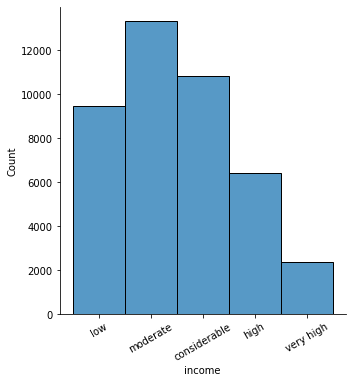

In [29]:
incomes = pd.cut(enriched_dtevent.income, 5, labels=['low', 'moderate' ,'considerable', 'high', 'very high'],retbins=True)
g = sns.displot(incomes[0])
g.set_xticklabels(rotation=30)

,total,completed,completed_percentage
cat_income,,,
low,9452,3561,37.674566
moderate,13307,6142,46.156158
considerable,10813,5585,51.650791
high,6414,3507,54.677268
very high,2353,1372,58.308542


<AxesSubplot:xlabel='cat_income'>

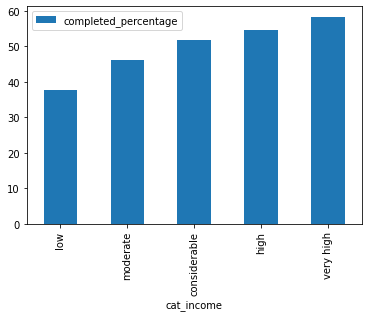

In [30]:
def income_completed_percentage(income_df,title):
        income_df = income_df.copy()
        incomes = pd.cut(income_df.income, 5, labels=['low', 'moderate' ,'considerable', 'high', 'very high'],retbins=True)
        income_df['cat_income'] = incomes[0]
        cat_count = income_df.groupby(by='cat_income').cat_income.count()
        cat_completed_count = income_df.groupby(by='cat_income').completed.sum()
        cats = pd.concat([pd.DataFrame(cat_count), pd.DataFrame(cat_completed_count)], axis=1)
        cats.columns=['total','completed']
        cats['completed_percentage'] = cats.completed/cats.total*100
        cats.style.set_caption(title)
        return cats

completed_by_income = income_completed_percentage(enriched_dtevent, "income").sort_values(by='completed_percentage')
display(completed_by_income)
completed_by_income.plot.bar(y='completed_percentage')
# todo use sns like below to draw the chart